# Nowotarski的手法
- LightGBMで trend 予測
- LSTMで residual 予測（短期変動）
- 最終価格 = trend_pred + seasonal（固定） + residual_pred

In [30]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
from scipy.optimize import minimize_scalar

import pickle
import random
import importlib
import sys
import joblib

import shap
from pdpbox import pdp
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [3]:
import common

# モジュールの再読み込み
importlib.reload(common)

_common = common.Common()
_common.BASE_PATH

PosixPath('/Users/iwasakitakahiro/github')

In [4]:
common_func_path = _common.COMMON_FUNC_PATH
sys.path.append(str(common_func_path))

import func

importlib.reload(func)

<module 'func' from '/Users/iwasakitakahiro/github/共通関数/func.py'>

In [5]:
train_df = pd.read_csv('../output/中間データ/学習用データ/train_preprocessed.csv')

In [6]:
train_df[_common.UNIQUE_KEY_COLS] = pd.to_datetime(train_df[_common.UNIQUE_KEY_COLS])
train_df = train_df.sort_values(_common.UNIQUE_KEY_COLS).set_index(_common.UNIQUE_KEY_COLS)

price_series = train_df[_common.TARGET_COL]

In [7]:
# STL分解（1ヶ月周期＝24時間×30日）
stl_result_for_model1 = STL(price_series, period=24*30).fit()
stl_result_for_model2 = STL(price_series, period=24).fit()

train_df['trend'] = stl_result_for_model1.trend
train_df['seasonal'] = stl_result_for_model2.seasonal
train_df['residual'] = stl_result_for_model2.resid

# モデル1用に1ヶ月単位で集約（例：月平均）
model1_df = train_df.resample('M').mean().reset_index()
model2_df = train_df.copy()

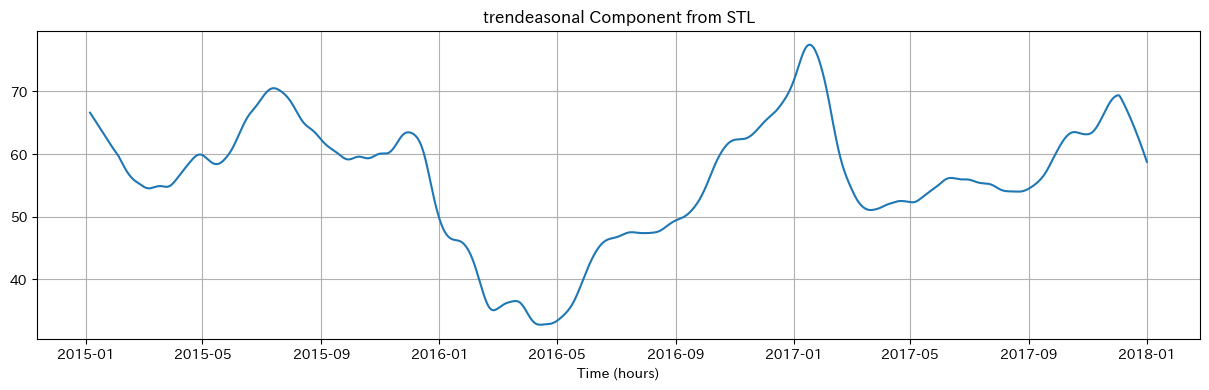

In [8]:
import matplotlib.pyplot as plt
trend = stl_result_for_model1.trend

plt.figure(figsize=(15,4))
plt.plot(trend[:100000])  # 最初の1000時間分だけ表示
plt.title("trendeasonal Component from STL")
plt.xlabel("Time (hours)")
plt.grid()
plt.show()

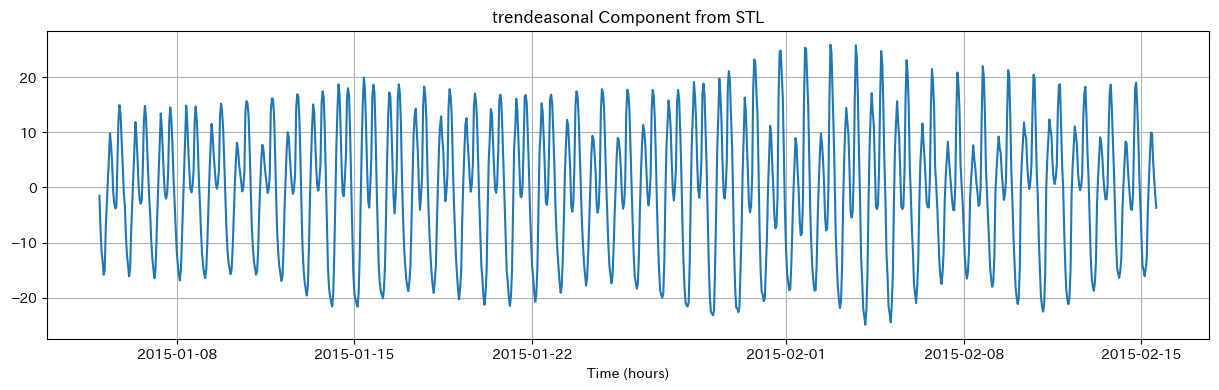

In [9]:
import matplotlib.pyplot as plt
seasonal = stl_result_for_model2.seasonal

plt.figure(figsize=(15,4))
plt.plot(seasonal[:1000])  # 最初の1000時間分だけ表示
plt.title("trendeasonal Component from STL")
plt.xlabel("Time (hours)")
plt.grid()
plt.show()

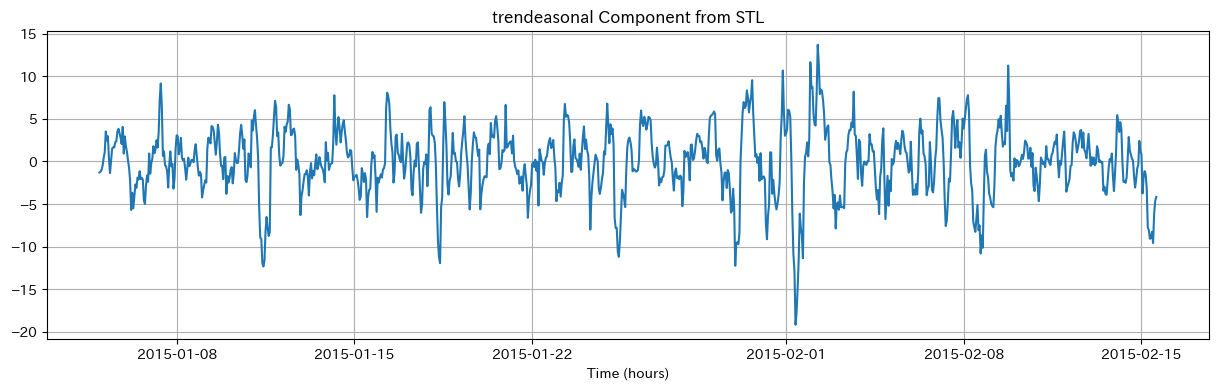

In [10]:
import matplotlib.pyplot as plt
residual = stl_result_for_model2.resid

plt.figure(figsize=(15,4))
plt.plot(residual[:1000])  # 最初の1000時間分だけ表示
plt.title("trendeasonal Component from STL")
plt.xlabel("Time (hours)")
plt.grid()
plt.show()

## Trend(LightGBM)

In [11]:
X_train = model1_df.drop(columns=[_common.TARGET_COL, _common.UNIQUE_KEY_COLS, 'trend', 'seasonal', 'residual'])
y_train = model1_df['trend']

In [12]:
# 再現性確保のための固定シード
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Optunaのシードも固定
sampler = optuna.samplers.TPESampler(seed=SEED)

# LightGBMにも同様に
default_params = {
    'objective': 'regression_l2',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'random_state': SEED,
    'verbosity': -1
}

tscv = TimeSeriesSplit(n_splits=5)

#### ハイパーパラメータチューニング

In [13]:
# 最適化の対象関数
def objective(trial):
    return func.run_optuna(
        trial=trial,
        features=X_train,         # 特徴量データフレーム
        target=y_train,           # 目的変数
        cv_strategy=tscv,         # ← partition_col → cv_strategy に変更済み
        model_name='lgb',
        default_columns=default_params,
        metric='rmse',
        random_seed=SEED
    )

# Optuna スタディの作成・実行
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=50, timeout=1800)

# 最良トライアルの結果
trial = study.best_trial
lgb_params = default_params | trial.params

# 結果の表示
print('Best trial:')
print(f'RMSE: {trial.value:.4f}')
print('Params:')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2025-06-14 23:12:25,966] A new study created in memory with name: no-name-6c39a763-02c6-4fc7-9f8d-4535a6c3730d
[I 2025-06-14 23:12:26,013] Trial 0 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.015542448978618607, 'num_leaves': 74, 'feature_fraction': 0.8875455478014229, 'bagging_fraction': 0.9570717167427538, 'bagging_freq': 8}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,039] Trial 1 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.01873236473539007, 'num_leaves': 50, 'feature_fraction': 0.9603744355070039, 'bagging_fraction': 0.991627870736741, 'bagging_freq': 9}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,063] Trial 2 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.02279382816537334, 'num_leaves': 66, 'feature_fraction': 0.9366925870344273, 'bagging_fraction': 0.94254040539658, 'bagging_freq': 4}. Best is trial 0 with value: 10.25131505627178

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training

[I 2025-06-14 23:12:26,191] Trial 6 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.07398222518217204, 'num_leaves': 61, 'feature_fraction': 0.9604295284160318, 'bagging_fraction': 0.828753364902913, 'bagging_freq': 8}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,225] Trial 7 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.05065021674897941, 'num_leaves': 46, 'feature_fraction': 0.984973525723113, 'bagging_fraction': 0.8884281510808354, 'bagging_freq': 10}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,258] Trial 8 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.011476493704368122, 'num_leaves': 43, 'feature_fraction': 0.8094710557603031, 'bagging_fraction': 0.934976188716466, 'bagging_freq': 6}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,293] Trial 9 finished with value: 10.251315056271789 and parameters: {'learning_rate': 

Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early st

[I 2025-06-14 23:12:26,411] Trial 12 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.017790915955779123, 'num_leaves': 82, 'feature_fraction': 0.8946550376710924, 'bagging_fraction': 0.9702080547756554, 'bagging_freq': 8}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,453] Trial 13 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.01582615930448371, 'num_leaves': 52, 'feature_fraction': 0.8462113131273871, 'bagging_fraction': 0.91896341211869, 'bagging_freq': 4}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,491] Trial 14 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.02603116502306341, 'num_leaves': 34, 'feature_fraction': 0.9964108762821082, 'bagging_fraction': 0.9693769516288284, 'bagging_freq': 7}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,533] Trial 15 finished with value: 10.251315056271789 and parameters: {'learning_rat

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training

[I 2025-06-14 23:12:26,615] Trial 17 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.014084362455275341, 'num_leaves': 50, 'feature_fraction': 0.9438179797246024, 'bagging_fraction': 0.8109006534834345, 'bagging_freq': 4}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,654] Trial 18 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.028345812519650772, 'num_leaves': 74, 'feature_fraction': 0.8469191013905162, 'bagging_fraction': 0.9524333358600283, 'bagging_freq': 9}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,695] Trial 19 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.09902292356250053, 'num_leaves': 88, 'feature_fraction': 0.9715085062852715, 'bagging_fraction': 0.9945443596454608, 'bagging_freq': 7}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,742] Trial 20 finished with value: 10.251315056271789 and parameters: {'learning_

Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early st

[I 2025-06-14 23:12:26,820] Trial 22 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.019218147575989417, 'num_leaves': 68, 'feature_fraction': 0.9041137308685285, 'bagging_fraction': 0.9761069807820648, 'bagging_freq': 2}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,860] Trial 23 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.02498472930294462, 'num_leaves': 80, 'feature_fraction': 0.9466936594986948, 'bagging_fraction': 0.9579356744687073, 'bagging_freq': 3}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,903] Trial 24 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.013093211773404206, 'num_leaves': 62, 'feature_fraction': 0.8798709662028672, 'bagging_fraction': 0.9002274277026773, 'bagging_freq': 5}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:26,946] Trial 25 finished with value: 10.251315056271789 and parameters: {'learning_

Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early st

[I 2025-06-14 23:12:27,027] Trial 27 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.042434846729101396, 'num_leaves': 89, 'feature_fraction': 0.921312944553129, 'bagging_fraction': 0.9416541860687155, 'bagging_freq': 3}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:27,067] Trial 28 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.01802856634435621, 'num_leaves': 77, 'feature_fraction': 0.9599161450179723, 'bagging_fraction': 0.9629154396607933, 'bagging_freq': 9}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:27,108] Trial 29 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.03421004093037488, 'num_leaves': 65, 'feature_fraction': 0.8484535060585111, 'bagging_fraction': 0.9510358034735021, 'bagging_freq': 8}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:27,151] Trial 30 finished with value: 10.251315056271789 and parameters: {'learning_ra

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training

[I 2025-06-14 23:12:27,236] Trial 32 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.05195585238064371, 'num_leaves': 72, 'feature_fraction': 0.8288066028844543, 'bagging_fraction': 0.8861648133753759, 'bagging_freq': 9}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:27,275] Trial 33 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.02330206823059211, 'num_leaves': 61, 'feature_fraction': 0.8042652135909181, 'bagging_fraction': 0.9574739377015374, 'bagging_freq': 9}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:27,317] Trial 34 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.04006519684856798, 'num_leaves': 58, 'feature_fraction': 0.9709512247929044, 'bagging_fraction': 0.9293267257763017, 'bagging_freq': 10}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:27,356] Trial 35 finished with value: 10.251315056271789 and parameters: {'learning_r

Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early st

[I 2025-06-14 23:12:27,446] Trial 37 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.05117787995862289, 'num_leaves': 78, 'feature_fraction': 0.8614634902206042, 'bagging_fraction': 0.9383152636469033, 'bagging_freq': 6}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:27,529] Trial 38 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.06214031181340991, 'num_leaves': 39, 'feature_fraction': 0.9568269635871635, 'bagging_fraction': 0.9629715909291766, 'bagging_freq': 10}. Best is trial 0 with value: 10.251315056271789.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training

[I 2025-06-14 23:12:27,735] Trial 39 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.02033684963202944, 'num_leaves': 57, 'feature_fraction': 0.9063489153986163, 'bagging_fraction': 0.8895229649557832, 'bagging_freq': 8}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:27,786] Trial 40 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.012019915686338438, 'num_leaves': 71, 'feature_fraction': 0.981313709990291, 'bagging_fraction': 0.9846492076328691, 'bagging_freq': 5}. Best is trial 0 with value: 10.251315056271789.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training

[I 2025-06-14 23:12:27,841] Trial 41 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.016601500318359972, 'num_leaves': 76, 'feature_fraction': 0.8145281441974558, 'bagging_fraction': 0.8531773490300271, 'bagging_freq': 9}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:27,934] Trial 42 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.029821266791864656, 'num_leaves': 85, 'feature_fraction': 0.8008955130394702, 'bagging_fraction': 0.8644529741077275, 'bagging_freq': 10}. Best is trial 0 with value: 10.251315056271789.


Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early st

[I 2025-06-14 23:12:28,022] Trial 43 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.01828869747248123, 'num_leaves': 64, 'feature_fraction': 0.8181904704401539, 'bagging_fraction': 0.8753854894090775, 'bagging_freq': 9}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:28,070] Trial 44 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.023791997444459763, 'num_leaves': 31, 'feature_fraction': 0.8347778381553856, 'bagging_fraction': 0.836194982955352, 'bagging_freq': 8}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:28,117] Trial 45 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.03569079500747422, 'num_leaves': 73, 'feature_fraction': 0.8848618149832269, 'bagging_fraction': 0.8754436578867121, 'bagging_freq': 10}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:28,161] Trial 46 finished with value: 10.251315056271789 and parameters: {'learning_r

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training

[I 2025-06-14 23:12:28,260] Trial 48 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.046085904331152776, 'num_leaves': 54, 'feature_fraction': 0.8379593758911964, 'bagging_fraction': 0.9961550222634286, 'bagging_freq': 10}. Best is trial 0 with value: 10.251315056271789.
[I 2025-06-14 23:12:28,304] Trial 49 finished with value: 10.251315056271789 and parameters: {'learning_rate': 0.02679610230657051, 'num_leaves': 91, 'feature_fraction': 0.9332577260823576, 'bagging_fraction': 0.9679625496944976, 'bagging_freq': 8}. Best is trial 0 with value: 10.251315056271789.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Training

#### OOF予測を作成

In [14]:
def get_lgb_oof_predictions(X, y, lgb_params, n_splits=5, num_boost_round=1000, es=50):
    """
    LightGBMで時系列交差検証を用いたOOF予測を作成
    """
    oof_preds = np.zeros(len(X))
    models = []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"Fold {fold+1}/{n_splits}")

        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dval = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(
            lgb_params,
            dtrain,
            valid_sets=[dval],
            num_boost_round=num_boost_round,
            callbacks=[
                lgb.early_stopping(es),
                lgb.log_evaluation(period=0),
            ]
        )

        preds = model.predict(X_val, num_iteration=model.best_iteration)
        oof_preds[val_idx] = preds
        models.append(model)

    return oof_preds, models

In [15]:
# OOF予測
oof_preds_model1, model1_folds = get_lgb_oof_predictions(
    X_train, y_train,
    lgb_params,
    n_splits=5
)

Fold 1/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.76782
Fold 2/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 22.2896
Fold 3/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.09553
Fold 4/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.32136
Fold 5/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.78224


In [16]:
model1_df['price_day_ahead_pred'] = oof_preds_model1

In [17]:
model1_df['date'] = model1_df[_common.UNIQUE_KEY_COLS].dt.date

model2_df = model2_df.reset_index()
model2_df['date'] = model2_df[_common.UNIQUE_KEY_COLS].dt.date

model2_df = model2_df.merge(
    model1_df[['date', 'price_day_ahead_pred']],
    on='date',
    how='left'
)

#### 全データで学習

In [18]:
# LightGBM Dataset の作成
lgb_train = lgb.Dataset(X_train, label=y_train)

callbacks = [
    lgb.log_evaluation(period=50)
]

# モデルの再学習（最終学習）
trend_model = lgb.train(
    lgb_params,
    train_set=lgb_train,
    callbacks=callbacks,
)

# トレーニングデータで予測
y_train_pred = trend_model.predict(X_train)

# RMSEを計算
final_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"LightGBMのトレーニングRMSE: {final_rmse:.4f}")

LightGBMのトレーニングRMSE: 9.6678


In [19]:
# 保存用のディクショナリにまとめる
model_package = {
    'model': trend_model,
    'feature_name': X_train.columns.tolist()
}

# 保存
with open('../output/モデル/trend_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

## Seasonal

In [20]:
# STLで得た seasonal 成分から固定パターンを作成
train_df = train_df.reset_index()
train_df['weekday'] = train_df[_common.UNIQUE_KEY_COLS].dt.weekday
train_df['hour'] = train_df[_common.UNIQUE_KEY_COLS].dt.hour

# 平均seasonalパターンを計算
seasonal_table = train_df.groupby(['weekday', 'hour'])['seasonal'].mean()

# model2_df に weekday/hour を割り当てて seasonal 値を追加
model2_df['weekday'] = model2_df[_common.UNIQUE_KEY_COLS].dt.weekday
model2_df['hour'] = model2_df[_common.UNIQUE_KEY_COLS].dt.hour

model2_df['seasonal'] = model2_df.apply(
    lambda row: seasonal_table.loc[(row['weekday'], row['hour'])],
    axis=1
)

In [28]:
seasonal_table.reset_index().to_csv('seasonal_table.csv', index=False)

## Residual(LSTM)

In [21]:
model2_df = model2_df[model2_df['price_day_ahead_pred'].notnull()]

In [33]:
# 前処理
exclude_cols = [_common.TARGET_COL, _common.UNIQUE_KEY_COLS, 'residual', 'date']  # 目的変数＋timeは除外
features = [col for col in model2_df.columns if col not in exclude_cols]
target_col = 'residual'

scaler = MinMaxScaler()
train_features = scaler.fit_transform(model2_df[features])

# --- LSTM用の時系列ウィンドウデータ作成 ---
SEQ_LEN = 24
X, y = [], []
for i in range(len(train_features) - SEQ_LEN):
    X.append(train_features[i:i+SEQ_LEN])
    y.append(model2_df[target_col].iloc[i+SEQ_LEN])
X = np.array(X)
y = np.array(y)

joblib.dump(train_features, 'scaler_residual_model.pkl')

['scaler_residual_model.pkl']

#### パラメータチューニング

In [23]:
def create_lstm_attention_model(input_shape, units, num_layers, dropout, lr, l2_lambda, dense_units=32):
    inputs = Input(shape=input_shape)

    x = inputs
    for i in range(num_layers):
        x = LSTM(units, return_sequences=True, dropout=dropout,
                 kernel_regularizer=l2(l2_lambda))(x)

    # Attention (Self-Attention)
    attention_output = Attention()([x, x])  # shape: [batch, time, units]
    context_vector = GlobalAveragePooling1D()(attention_output)  # shape: [batch, units]

    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda))(context_vector)
    output = Dense(1, activation='linear', kernel_regularizer=l2(l2_lambda))(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=RMSprop(learning_rate=lr), loss='mse')
    return model

def objective(trial):
    units = trial.suggest_categorical('units', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2)
    l2_lambda = trial.suggest_float('l2', 1e-7, 1e-3, log=True)

    tscv = TimeSeriesSplit(n_splits=3)
    rmses = []
    for train_idx, val_idx in tscv.split(X):  # あなたのX, yのウィンドウ化後配列を前提
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = create_lstm_attention_model((X.shape[1], X.shape[2]), units, num_layers, dropout, learning_rate, l2_lambda)
        es = EarlyStopping(patience=20, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

        model.fit(
            X_train, y_train,
            epochs=200,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=0,
            callbacks=[es, reduce_lr]
        )

        y_pred = model.predict(X_val).flatten()
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return np.mean(rmses)

# --- Optunaでパラメータ探索 ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print("Best params:", study.best_params)
print("Best CV RMSE:", study.best_value)

[I 2025-06-14 23:12:28,803] A new study created in memory with name: no-name-eb078461-8d3c-4ad4-9675-fe8e559eb688


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-06-14 23:12:50,712] Trial 0 finished with value: 2.8444422895515022 and parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.1946411657873629, 'batch_size': 16, 'lr': 0.005198935987326601, 'l2': 3.091101891175757e-07}. Best is trial 0 with value: 2.8444422895515022.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-06-14 23:13:02,719] Trial 1 finished with value: 2.8465323924653663 and parameters: {'units': 64, 'num_layers': 1, 'dropout': 0.16652622617013868, 'batch_size': 16, 'lr': 0.0037250091657346244, 'l2': 0.0008511953439256746}. Best is trial 0 with value: 2.8444422895515022.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2025-06-14 23:13:26,509] Trial 2 finished with value: 2.852814043064768 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.3835263745620864, 'batch_size': 64, 'lr': 0.003996957167219134, 'l2': 0.0003255591380055166}. Best is trial 0 with value: 2.8444422895515022.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[I 2025-06-14 23:14:11,725] Trial 3 finished with value: 2.8463174721668594 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.3942511392011735, 'batch_size': 16, 'lr': 0.0038049223736661745, 'l2': 1.63903106341779e-05}. Best is trial 0 with value: 2.8444422895515022.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[I 2025-06-14 23:14:28,186] Trial 4 finished with value: 2.8481281161993963 and parameters: {'units': 32, 'num_layers': 2, 'dropout': 0.22664189485153197, 'batch_size': 32, 'lr': 0.008028684498773322, 'l2': 0.000435985182150058}. Best is trial 0 with value: 2.8444422895515022.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-06-14 23:14:38,814] Trial 5 finished with value: 2.850926825610982 and parameters: {'units': 64, 'num_layers': 1, 'dropout': 0.2229075027092299, 'batch_size': 64, 'lr': 0.005313880483169166, 'l2': 0.000216008807719567}. Best is trial 0 with value: 2.8444422895515022.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2025-06-14 23:14:54,495] Trial 6 finished with value: 2.87152970955963 and parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.10485308943781546, 'batch_size': 64, 'lr': 0.002076958352654987, 'l2': 5.249305104527125e-06}. Best is trial 0 with value: 2.8444422895515022.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2025-06-14 23:15:04,663] Trial 7 finished with value: 2.8671624030187455 and parameters: {'units': 64, 'num_layers': 1, 'dropout': 0.4578747958248086, 'batch_size': 64, 'lr': 0.003081055013064027, 'l2': 8.6080345819977e-07}. Best is trial 0 with value: 2.8444422895515022.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-06-14 23:15:16,266] Trial 8 finished with value: 2.8474353091639735 and parameters: {'units': 32, 'num_layers': 1, 'dropout': 0.4577524251990619, 'batch_size': 16, 'lr': 0.00789874106329987, 'l2': 2.208200913134938e-07}. Best is trial 0 with value: 2.8444422895515022.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-06-14 23:15:25,481] Trial 9 finished with value: 2.876516368646359 and parameters: {'units': 32, 'num_layers': 1, 'dropout': 0.2845463732868747, 'batch_size': 32, 'lr': 0.004492712631967219, 'l2': 4.1036100533114987e-05}. Best is trial 0 with value: 2.8444422895515022.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-06-14 23:15:58,144] Trial 10 finished with value: 2.8266099259019213 and parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.10563085138813097, 'batch_size': 16, 'lr': 0.00977346634323009, 'l2': 1.8612922608440822e-07}. Best is trial 10 with value: 2.8266099259019213.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[I 2025-06-14 23:16:21,879] Trial 11 finished with value: 2.8270448634001304 and parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.11076986975022714, 'batch_size': 16, 'lr': 0.009805387378240708, 'l2': 2.1466992559430428e-07}. Best is trial 10 with value: 2.8266099259019213.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2025-06-14 23:16:45,449] Trial 12 finished with value: 2.855808405850508 and parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.1064353391654799, 'batch_size': 16, 'lr': 0.009953461290014969, 'l2': 1.996418987731179e-06}. Best is trial 10 with value: 2.8266099259019213.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-06-14 23:17:09,598] Trial 13 finished with value: 2.848399791402562 and parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.15005737625568485, 'batch_size': 16, 'lr': 0.009703770415538056, 'l2': 1.2603810508325115e-07}. Best is trial 10 with value: 2.8266099259019213.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[I 2025-06-14 23:18:00,102] Trial 14 finished with value: 2.8539920883578076 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.2840758004521093, 'batch_size': 16, 'lr': 0.007620106087719614, 'l2': 7.365436391958702e-07}. Best is trial 10 with value: 2.8266099259019213.


Best params: {'units': 64, 'num_layers': 2, 'dropout': 0.10563085138813097, 'batch_size': 16, 'lr': 0.00977346634323009, 'l2': 1.8612922608440822e-07}
Best CV RMSE: 2.8266099259019213


#### OOF予測を作成

In [24]:
def lstm_oof_predictions(X_array, y_array, model1_trend_pred, model2_df, best_params, n_splits=5):
    oof_preds_resid = np.full(len(y_array), np.nan)
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_array)):
        print(f'Fold {fold+1}/{n_splits}')

        X_train, X_val = X_array[train_idx], X_array[val_idx]
        y_train, y_val = y_array[train_idx], y_array[val_idx]

        model = create_lstm_attention_model(
            input_shape=(X_array.shape[1], X_array.shape[2]),
            units=best_params['units'],
            num_layers=best_params['num_layers'],
            dropout=best_params['dropout'],
            lr=best_params['lr'],
            l2_lambda=best_params['l2']
        )

        model.fit(
            X_train, y_train,
            epochs=200,
            batch_size=best_params['batch_size'],
            validation_data=(X_val, y_val),
            verbose=0,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(patience=10)
            ]
        )

        preds = model.predict(X_val).flatten()
        oof_preds_resid[val_idx] = preds
    
    # --- 最終価格予測を合成 ---
    trend_pred = model1_trend_pred[:len(oof_preds_resid)]  # モデル1 OOF
    seasonal = model2_df['seasonal'].values[:len(oof_preds_resid)]
    final_pred = trend_pred + seasonal + oof_preds_resid

    # --- 実測値 ---
    actual = model2_df['target_col'].values[:len(oof_preds_resid)]

    rmse = np.sqrt(mean_squared_error(actual[~np.isnan(final_pred)], final_pred[~np.isnan(final_pred)]))
    print(f'最終価格のOOF RMSE: {rmse:.4f}')

    return final_pred, oof_preds_resid

#### 全データで学習

In [25]:
best_params = study.best_params
units = best_params['units']
num_layers = best_params['num_layers']
dropout = best_params['dropout']
batch_size = best_params['batch_size']
learning_rate = best_params['lr']
l2_lambda = best_params['l2']

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1672 - learning_rate: 0.0098
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4519 - learning_rate: 0.0098
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0126 - learning_rate: 0.0098
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2198 - learning_rate: 0.0098
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1647 - learning_rate: 0.0098
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.4935 - learning_rate: 0.0098
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7754 - learning_rate: 0.0098
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0974 - learning_rate: 0.0098
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0751 - learning_rate: 0.0098
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1123 - learning_rate: 0.0098
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8341 - learning_rate: 0.0098
Epoch 1

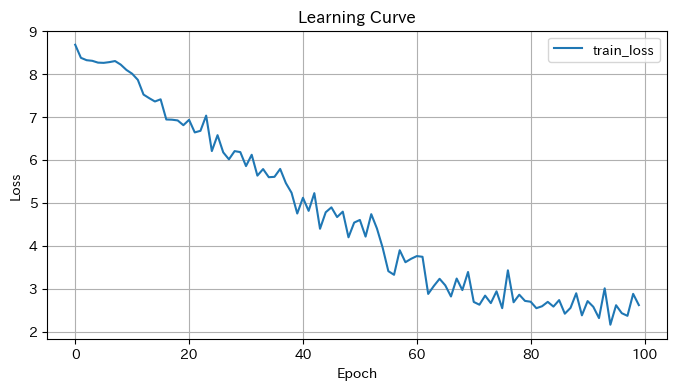

In [26]:
X_all, y_all = [], []
for i in range(len(train_features) - SEQ_LEN):
    X_all.append(train_features[i:i+SEQ_LEN])
    y_all.append(model2_df[target_col].iloc[i+SEQ_LEN])
X_all = np.array(X_all)
y_all = np.array(y_all)

# --- Attention付きLSTMモデルの構築 ---
residual_model = create_lstm_attention_model(
    input_shape=(SEQ_LEN, X_all.shape[2]),
    units=units,
    num_layers=num_layers,
    dropout=dropout,
    lr=learning_rate,
    l2_lambda=l2_lambda
)

# --- コールバックの設定 ---
es = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# --- 学習 ---
history = residual_model.fit(
    X_all, y_all,
    epochs=100,
    batch_size=batch_size,
    verbose=1,
    callbacks=[es, reduce_lr]
)

# --- 全データでの予測とRMSE計算 ---
y_pred = residual_model.predict(X_all).flatten()
rmse = np.sqrt(mean_squared_error(y_all, y_pred))
print(f"Train RMSE: {rmse:.3f}")

# --- 学習曲線の可視化 ---
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
residual_model.save('../output/モデル/residual_model.keras')

## Trend + Seasonal + Residual